In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
import subprocess
import os

In [2]:
#getting files from server from server
# sudo tailscale up before running
def get_kid_timestreams(four_kid_num):
    #four_kid_num must be of the format xxxx, i.e 0001, 0150, 1001
    print(f'Downloading i timestream kid{four_kid_num}')
    subprocess.run(["scp", 
                    f"player1@cube:/media/player1/blast2020fc1/fc1/extracted/roach3_2020-01-06-06-21-56/i_kid{four_kid_num}_roach3", 
                    "/home/triv/Desktop/localBLASTTNG/roach3_2020-01-06-06-21-56"])
    print('Done')
    print(f'Downloading q timestream kid{four_kid_num}')
    subprocess.run(["scp", 
                    f"player1@cube:/media/player1/blast2020fc1/fc1/extracted/roach3_2020-01-06-06-21-56/q_kid{four_kid_num}_roach3", 
                    "/home/triv/Desktop/localBLASTTNG/roach3_2020-01-06-06-21-56"])
    print('Done')
    return

def targ(chan, dir):
    '''resonant frequency calibration sweep for given chan'''
    # assumes global dir_data and dir_targ
    
    # get list of targ files 
     # sort and remove bottom 4 (not relevant) files
    targ_file_list = os.listdir(dir)
    targ_file_list.sort()
    targ_file_list = targ_file_list[:-4]
    
    # load all targ files data
    dat = np.array([
        np.fromfile(f"{dir}/{f}", dtype = '<f')
        for f in targ_file_list
    ])
    
    # filter data to I and Q data for given channel
    # I = dat[:,chan,1]
    # Q = dat[:,chan,2]
    I = dat[::2,chan]
    Q = dat[1::2,chan]
    
    return I,Q

def Δfx_grad(Q, I, Qf, If):
    '''Calculate Δfx from 'gradient' method
    I: I(t): timestream S21 real component
    Q: Q(t): timestream S21 imaginary component
    If: I(f): frequency sweep S21 real component
    Qf: Q(f): frequency sweep S21 imaginary component'''
    
    dIfdf = np.diff(If)/1e3        # Δx is const. so Δy=dI/df
    dQfdf = np.diff(Qf)/1e3        # /1e3 for units
    dIfdff0 = dIfdf[len(dIfdf)//2] # dI(f)/df at f0
    dQfdff0 = dQfdf[len(dQfdf)//2] # assume f0 is centre index
    I_n = I - np.mean(I)           # centre values on 0
    Q_n = Q - np.mean(Q)           #
    
    den = dIfdff0**2 + dQfdff0**2  # 
    
    numx = ((I_n*dIfdff0 + Q_n*dQfdff0))
    Δfx = numx/den
    
    numy = ((Q_n*dIfdff0 - I_n*dQfdff0))
    Δfy = numy/den
    
    return Δfx

In [3]:
kid_nums = ['0100', '0200', '0300','0600']

# for i in kid_nums:
#     get_kid_timestreams(i)

In [4]:
#importing from dirfiles

#locations and folder
dir_base = '/home/triv/Desktop/localBLASTTNG/'
dir_master = dir_base + 'master_2020-01-06-06-21-22'
dir_roach3 = dir_base + 'roach3_2020-01-06-06-21-56'
dir_targ = dir_base + 'targ_sweep/Mon_Jan__6_06_00_34_2020'

roach_num = 3 #using roach 3 rn

mode_dirfile = gd.RDONLY
data_master = gd.dirfile(dir_master, mode_dirfile)
data_roach3 = gd.dirfile(dir_roach3)

#getting data
RAm = data_master.getdata(b'RA')
DECm = data_master.getdata(b'DEC')
master_time = data_master.getdata(b'TIME') + data_master.getdata(b'TIME_USEC')*1e-6
roach_time = data_roach3.getdata(b'ctime_built_roach3')

#detectors

many_phase_vals = []
many_absIQ_vals = []
many_Δf_vals = []
for n,k_num in enumerate(kid_nums):
    I_vals = data_roach3.getdata(f"i_kid{k_num}_roach3".encode('UTF-8'))
    Q_vals = data_roach3.getdata(f"q_kid{k_num}_roach3".encode('UTF-8'))
    If, Qf = targ(int(k_num) ,dir_targ)
    
    many_absIQ_vals.append(np.sqrt(I_vals**2 + Q_vals**2))
    many_phase_vals.append(np.arctan2(Q_vals, I_vals))
    many_Δf_vals.append(Δfx_grad(Q_vals, I_vals, Qf, If))


many_absIQ_vals = np.array(many_absIQ_vals)
many_phase_vals = np.array(many_phase_vals)
many_Δf_vals = np.array(many_Δf_vals)

def view_data():
    m_diff = np.diff(master_time)
    r_diff = np.diff(roach_time)
    print('RA & DEC shape: ', RAm.shape, DECm.shape)
    print(f"Detector array shape: {many_phase_vals.shape}")
    print(f"Detector Δf shape: {many_Δf_vals.shape}")
    print('Master time: ')
    print(f"    min: {np.min(master_time)}, max: {np.max(master_time)}, avg. diff: {np.mean(m_diff)}, clock speed: {1/np.mean(m_diff)}")
    print('Detector time: ')
    print(f"    min: {np.min(roach_time)}, max: {np.max(roach_time)}, avg. diff: {np.median(r_diff)}, clock speed: {1/np.median(r_diff)}")
    return
view_data()

RA & DEC shape:  (9830900,) (9830900,)
Detector array shape: (4, 46531631)
Detector Δf shape: (4, 46531631)
Master time: 
    min: 1578244880.069792, max: 1578343189.25718, avg. diff: 0.010000020078320739, clock speed: 99.99979921719574
Detector time: 
    min: 1578244917.5798242, max: 1578342886.964096, avg. diff: 0.002048015594482422, clock speed: 488.27753201396973


In [5]:
#setting scan area from RA and DEC master arrays
start = int(7.85e6)
stop = int(7.9722e6)

def show_scan_area():
    plt.scatter(RAm[7000000:7972200], DECm[7000000:7972200])
    plt.scatter(RAm[start:stop], DECm[start:stop])
    plt.show()
#show_scan_area()

#Scaling Master and Detector arrays by time
DETinds = np.array([np.searchsorted(roach_time, t, side='left') for t in master_time]) #finds closest index in roach time for each master time
DETinds[DETinds == len(roach_time)] = len(roach_time) - 1 # fixed max index bug from np.searchsorted

#Scaled arrays (can be used with each other)
RA = RAm[start:stop]
DEC = DECm[start:stop]
PH = many_phase_vals[:,DETinds][:,start:stop]
AMP = many_absIQ_vals[:,DETinds][:,start:stop]
DF = many_Δf_vals[:,DETinds][:,start:stop]

print(f"start: {start}, stop: {stop}")
print("Master: ", RA.shape, DEC.shape) 
print("Detectors: ", PH.shape, AMP.shape, DF.shape)

start: 7850000, stop: 7972200
Master:  (122200,) (122200,)
Detectors:  (4, 122200) (4, 122200) (4, 122200)


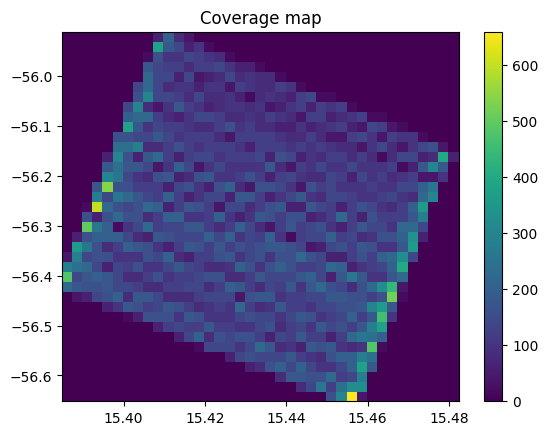

/home/triv/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/triv/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


df maps: (4, 37, 39)


In [6]:
#Build map array from pixels
ra_bin = 0.0025
dec_bin = 0.02
r_pix = np.arange(np.min(RA), np.max(RA), ra_bin)
d_pix = np.arange(np.min(DEC), np.max(DEC), dec_bin)

rr, dd = np.meshgrid(r_pix,d_pix)

#populate map

def fill_coverage_map():
    Z = np.zeros((len(d_pix),len(r_pix)))
    for i in range(len(d_pix)):
        for j in range(len(r_pix)): #loop over pixel map
            det_inds = (RA >= r_pix[j]) & (RA < (r_pix[j] + ra_bin)) & (DEC >= d_pix[i]) & (DEC < (d_pix[i] + dec_bin)) # bining RA and DEC into pixel
            pix_val = det_inds.sum() #counts ra&dec for each pixel
            Z[i,j] = pix_val 
    return Z
 
def fill_map(datastream, kid_n):
    """datastream : PH or AMPS"""
    Z = np.zeros((len(d_pix),len(r_pix)))
    for i in range(len(d_pix)):
        for j in range(len(r_pix)): #loop over pixel map
            det_inds = (RA >= r_pix[j]) & (RA < (r_pix[j] + ra_bin)) & (DEC >= d_pix[i]) & (DEC < (d_pix[i] + dec_bin)) # bining RA and DEC into pixel
            det_vals = datastream[kid_n, det_inds] #phase values at each pixel from ts
            pix_val = np.mean(det_vals)
            Z[i,j] = pix_val
    return Z

cov_map = fill_coverage_map()

def show_cov_map():
    plt.pcolor(rr,dd,cov_map)
    plt.title('Coverage map')
    plt.colorbar()
    plt.show()
show_cov_map()

phase_maps = np.array([fill_map(PH, kn) for kn in range(len(kid_nums))])
amp_maps = np.array([fill_map(AMP, kn) for kn in range(len(kid_nums))])
df_maps = np.array([fill_map(DF, kn) for kn in range(len(kid_nums))])

print(f"df maps: {df_maps.shape}")

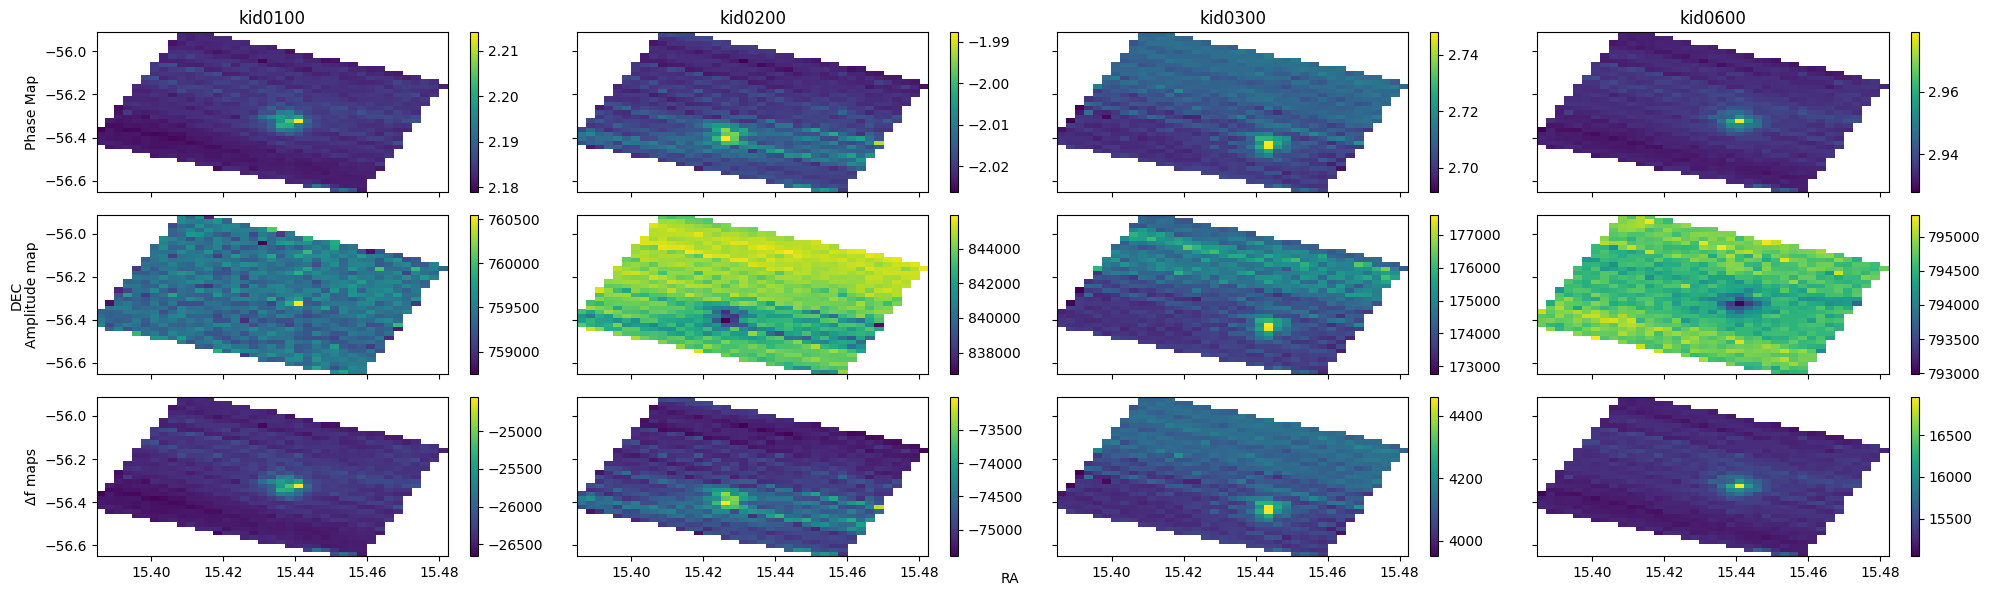

In [7]:
%matplotlib inline
def show_multi_maps():
    fig, (axs1, axs2, axs3) = plt.subplots(3, len(kid_nums), sharex=True, sharey=True, figsize=(20,6))
    for i,ax in enumerate(axs1):
        a = axs1[i].pcolor(rr,dd,phase_maps[i])
        b = axs2[i].pcolor(rr,dd,amp_maps[i])
        c = axs3[i].pcolor(rr,dd,df_maps[i])
        axs1[i].set_title(f'kid{kid_nums[i]}')
        fig.colorbar(a)
        fig.colorbar(b)
        fig.colorbar(c)
    
    axs1[0].set_ylabel("Phase Map")
    axs2[0].set_ylabel("Amplitude map")
    axs3[0].set_ylabel("Δf maps")
    fig.text(0.5, 0.02, 'RA', ha='center')
    fig.text(0, 0.5, 'DEC', va='center', rotation='vertical')
    plt.tight_layout()
    plt.savefig('pixel_map_ph_amp_df_comparision.png')
    
show_multi_maps()

## Multi Channel maps

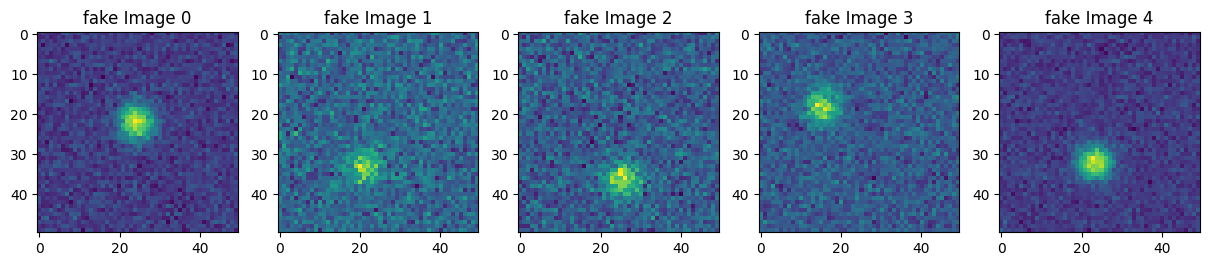

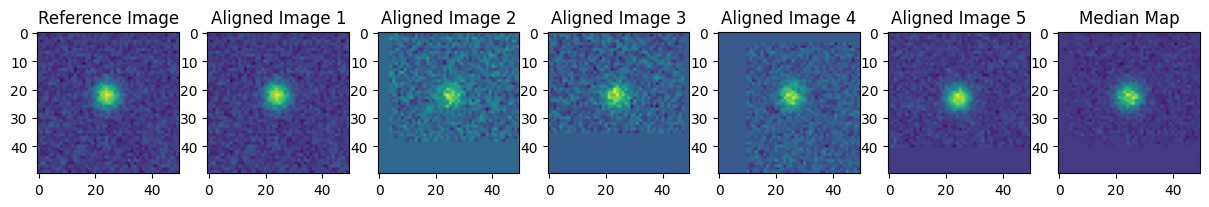

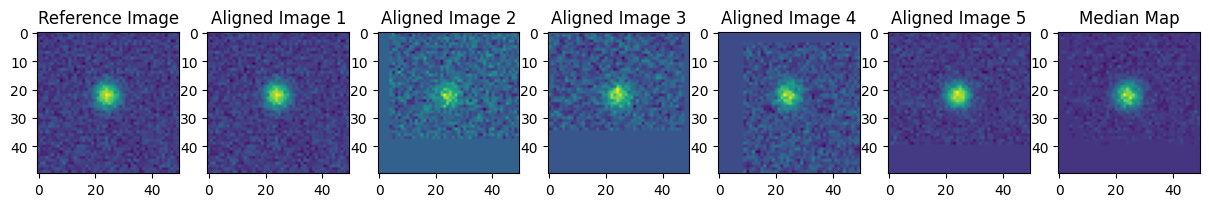

In [8]:
from ipynb.fs.full.map_from_single_dets import *

def find_brightest_pixel(image):
    # Find the indices of the maximum value in the 2D array
    indices = np.unravel_index(np.nanargmax(image, axis=None), image.shape)
    return indices


def align_images(images, fit_func):
    # Find the brightest pixel in the reference image
    reference_image = images[0]
    #brightest_pixel_ref = find_brightest_pixel(reference_image)
    #reference_center = fit_gaussian(reference_image)
    reference_center = fit_func(reference_image)

    # Initialize a list to store aligned images
    aligned_images = [reference_image]

    # Iterate through the rest of the images and align them
    for i in range(1, len(images)):
        current_image = images[i]

        # Find the brightest pixel in the current image
        current_center = fit_func(current_image)
        #print(f"current center : {current_center}")

        # Calculate the shift needed to align the current image with the reference image
        shift_amount = np.array(reference_center) - np.array(current_center)
        #print(f"shift amount : {shift_amount}")

        # Shift the current image
        aligned_image = shift(current_image, shift_amount,cval=np.nan, order=0)

        aligned_image = aligned_image/aligned_image[current_center]

        # Append the aligned image to the list
        aligned_images.append(aligned_image)

    return aligned_images

/home/triv/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


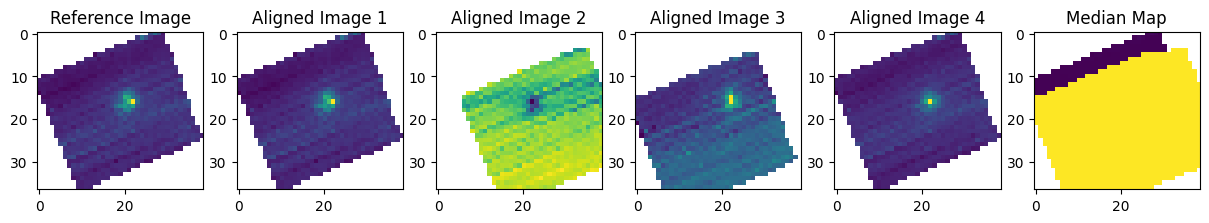

In [9]:
def multiDetectorMap_BrightestPixel():
    # Example usage:
    # images is a list of 2D NumPy arrays representing the astronomical images
    # Make sure all images have the same shape

    # Assuming you have a list of images like this:
    # images = [image1, image2, image3, ...]
    images = list(df_maps)

    def plotMaps(images, aligned_images):
        fig, axes = plt.subplots(1, len(aligned_images) + 2, figsize=(15, 5))
        axes[0].imshow(images[0], cmap='viridis')
        axes[0].set_title('Reference Image')
        for i, aligned_image in enumerate(aligned_images):
            axes[i+1].imshow(aligned_image, cmap='viridis')
            axes[i+1].set_title(f'Aligned Image {i+1}')
        axes[len(aligned_images) + 1].imshow(map_med, cmap='viridis')
        axes[len(aligned_images) + 1].set_title('Median Map')
        plt.savefig('alignment.png')
    
    # Align the images by brightest pixel and take median map
    aligned_images = align_images(images, find_brightest_pixel)
    #map_med = np.median(np.array(aligned_images), axis=0)

    map_med = np.zeros_like(aligned_images[0])
    for i in range(aligned_images[0].shape[0]):
        for j in range(aligned_images[0].shape[1]):
            map_med[i,j] = np.nanmedian(np.array([aligned_images[k][i,j] for k in range(len(aligned_images))]))
    
    plotMaps(images, aligned_images)

    # # Align the images with 2d gaussian and take median map
    # aligned_images = align_images(images, fit_gaussian)
    # map_med = np.median(aligned_images, axis=0)
    # plotMaps(images, aligned_images)

    return map_med


map_med = multiDetectorMap_BrightestPixel()

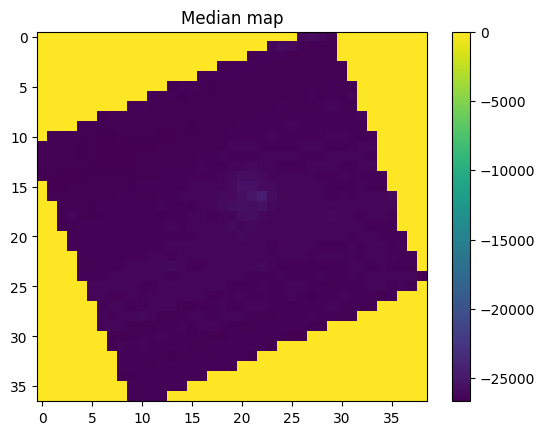

In [10]:
images = [df_maps[i] for i in [0]]
aligned_images = align_images(images, find_brightest_pixel)

overall_median = np.zeros_like(aligned_images[0])
for i in range(aligned_images[0].shape[0]):
    for j in range(aligned_images[0].shape[1]):
        overall_median[i,j] = np.nansum([aligned_images[k][i,j] for k in range(len(aligned_images))])/len(aligned_images) + 1

plt.imshow(overall_median)
plt.title('Median map')
plt.colorbar()
plt.show()

In [11]:
np.nansum([2,np.nan,np.nan,-23,-2,np.nan])

-23.0

In [12]:
np.nanmedian(aligned_images, axis=0).shape

(37, 39)

In [13]:
overall_median = np.zeros_like(aligned_images[0])
for i in range(aligned_images[0].shape[0]):
    for j in range(aligned_images[0].shape[1]):
        overall_median[i,j] = np.nanmedian(np.array([aligned_images[k][i,j] for k in range(len(aligned_images))]))

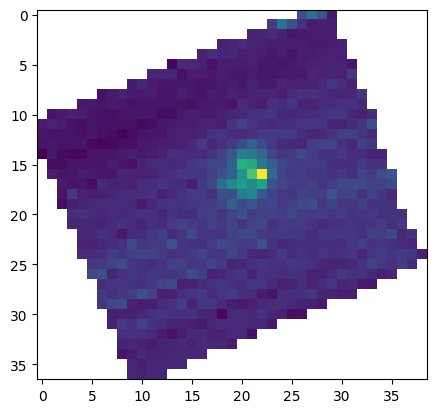

In [14]:
plt.imshow(overall_median)

In [15]:
overall_median

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])